In [26]:
import json
from collections import Counter

import nltk
import seaborn as sns
from nltk.corpus import stopwords

from config import TLCPaths

nltk.download('stopwords')
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 30})

UMLS_KEY = "43f9234c-4977-45f6-a440-2dda1b43d919"
import requests

[nltk_data] Downloading package stopwords to /home/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
# Load the dataset
with open(TLCPaths.project_data_path / 'TLC_UMLS.json') as f:
    data = json.load(f)


In [84]:
unique_sample_ids = set()
for entry in data:
    unique_sample_ids.add(entry['sample_id'])

In [85]:
print(f"original tlc: {4727 + 1745} in 4000 posts.")
print(f"tlc umls: {len(data)} in {len(unique_sample_ids)} posts.")

original tlc: 6472 in 4000 posts.
tlc umls: 6428 in 3009 posts.


In [96]:
6472 / 4000

1.618

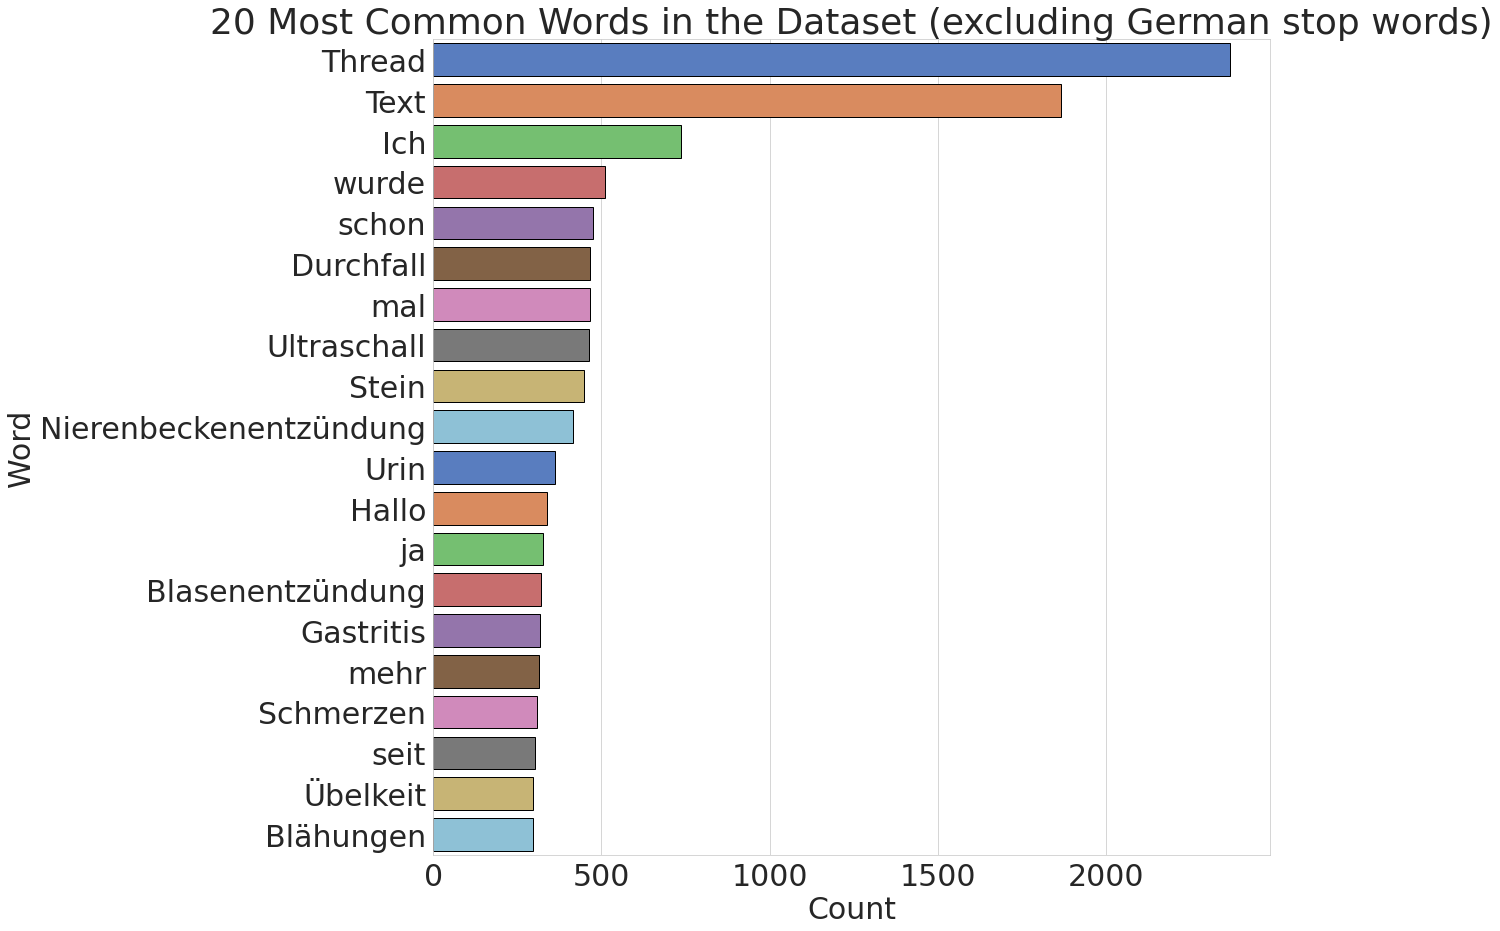

In [86]:
# Get the German stopwords from nltk
stop_words = set(stopwords.words('german'))

# Initialize a new counter for the words
filtered_word_counts = Counter()

mention_counts = Counter()
cui_counts = Counter()
sentence_lengths = []
mention_lengths = []
cuis = []
# Count the words in the sentences, excluding stopwords
for entry in data:
    sentence = entry['mention_sentence']
    words = re.findall(r'\b\w+\b', sentence)
    words = [word for word in words if word not in stop_words]
    filtered_word_counts.update(words)
    mention = entry['mention']
    cui = entry['cui']
    sentence = entry['mention_sentence']
    mention_span = entry['mention_spans']
    cuis.append(cui)

    # Count the mentions and cuis
    mention_counts[mention] += 1
    cui_counts[cui] += 1

    # Calculate the sentence and mention lengths
    sentence_lengths.append(len(sentence.split()))
    mention_lengths.append(mention_span[1] - mention_span[0] + 1)

# Get the 20 most common words
most_common_filtered_words = filtered_word_counts.most_common(20)

# Separate the words and their counts
filtered_words, filtered_counts = zip(*most_common_filtered_words)

# Convert the words and counts to a pandas DataFrame
filtered_word_counts_df = pd.DataFrame({
    'Word': filtered_words,
    'Count': filtered_counts
})

# Create a barplot of the word counts using seaborn
plt.figure(figsize=(15, 15))
sns.barplot(x='Count', y='Word', data=filtered_word_counts_df, errorbar=None, palette='muted',
            orient='h', edgecolor='k')
plt.title('20 Most Common Words in the Dataset (excluding German stop words)')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

In [87]:
# Calculate the number of unique mentions and cuis
num_unique_mentions = len(mention_counts)
num_unique_cuis = len(cui_counts)

# Calculate the average sentence and mention lengths
avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)
avg_mention_length = sum(mention_lengths) / len(mention_lengths)

# Calculate the most common mentions and cuis
most_common_mentions = mention_counts.most_common(10)
most_common_cuis = cui_counts.most_common(10)

num_unique_mentions, num_unique_cuis, avg_sentence_length, avg_mention_length

(492, 426, 19.33929682638457, 13.954107031736154)

In [88]:
def get_cui_name(api_key, cui):
    """Fetch the name of a CUI from the UMLS API."""

    url = f"https://uts-ws.nlm.nih.gov/rest/content/current/CUI/{cui}?apiKey={UMLS_KEY}"

    response = requests.get(url)
    response.raise_for_status()

    data = response.json()

    return data["result"]["name"]


most_common_cui_names = []
for cui, count in most_common_cuis:
    most_common_cui_names.append(get_cui_name(UMLS_KEY, cui))

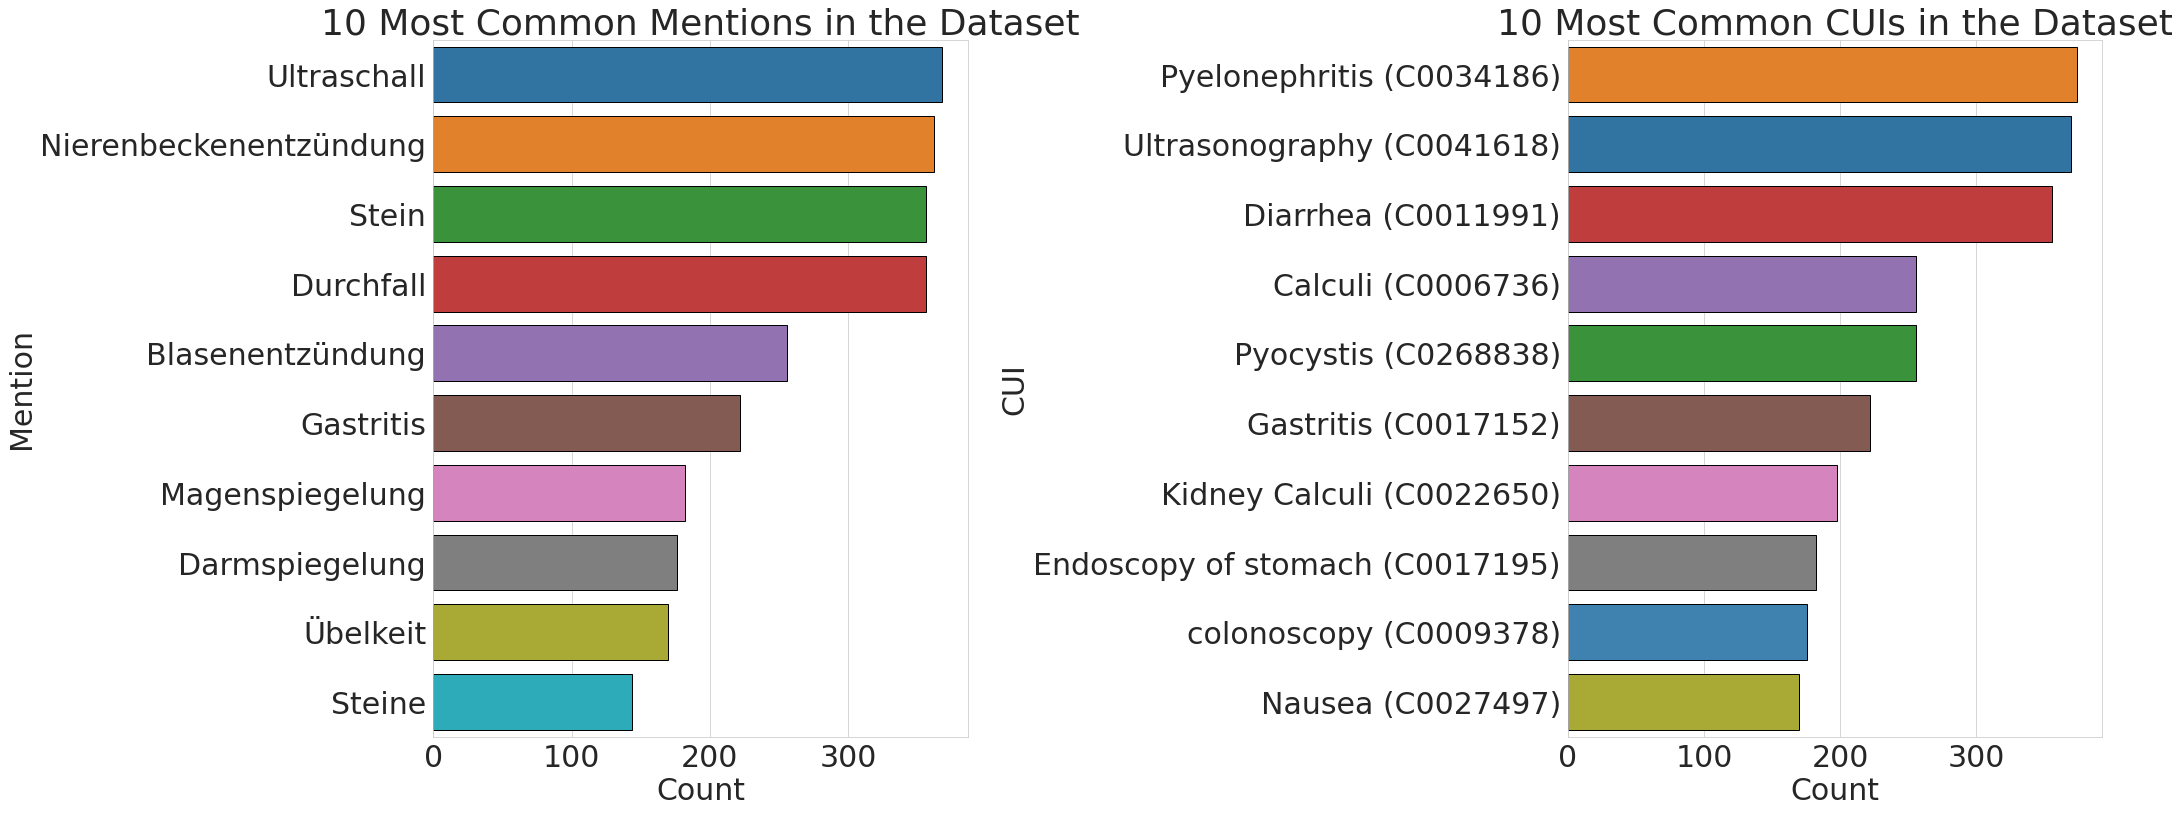

In [89]:
# Convert the most common mentions and cuis to pandas DataFrames
mentions_df = pd.DataFrame(most_common_mentions, columns=['Mention', 'Count'])
cuis_df = pd.DataFrame(most_common_cuis, columns=['CUI', 'Count'])
cuis_df['CUI'] = cuis_df['CUI'].apply(lambda x: get_cui_name(UMLS_KEY, x) + " (" + x + ")")

# Create the barplots
fig, ax = plt.subplots(1, 2, figsize=(30, 12))

first_palette = np.array(
    ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
     "#bcbd22", "#17becf", "#2E86C1"])
sec_indices = [1, 0, 3, 4, 2, 5, 6, 7, -1, 8]

sns.barplot(x='Count', y='Mention', data=mentions_df, ax=ax[0], errorbar=None,
            palette=sns.color_palette(first_palette, 14), orient='h', edgecolor='k')
ax[0].set_title('10 Most Common Mentions in the Dataset')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Mention')

sns.barplot(x='Count', y='CUI', data=cuis_df, ax=ax[1], errorbar=None,
            palette=sns.color_palette(first_palette[sec_indices], 14), orient='h', edgecolor='k')
ax[1].set_title('10 Most Common CUIs in the Dataset')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('CUI')

plt.tight_layout()
plt.show()




In [90]:
# analyze semantic types
import sqlite3

db_path = "/home/tim/PycharmProjects/py-umls/databases/umls.db"
db = sqlite3.connect(db_path)
cur = db.cursor()


def get_semantic_types(cuis):
    semantic_types = dict()
    for identifier in cuis:
        sql = f"SELECT * FROM descriptions WHERE CUI = ? LIMIT 1"

        try:
            res = next(cur.execute(sql, (identifier,)))[-1]
            semantic_types[identifier] = res.split("|")
        except StopIteration:
            print('Semantic type for cui ' + "'" + str(identifier) + "'" + ' not found')
    return semantic_types


semantic_types = get_semantic_types(cuis)
semantic_types = [t for l in semantic_types.values() for t in l]  # flattened values



In [91]:
def get_type_name(s_type: str):
    query_url = f"https://uts-ws.nlm.nih.gov/rest/semantic-network/2022AB/TUI/{s_type}?apiKey={UMLS_KEY}"
    try:
        name = requests.get(query_url).json()["result"]["name"]
    except KeyError:
        name = "unknown"
        print(f"Unknown semantic type: {s_type}")
    return name

In [92]:
type_counter = Counter(semantic_types)
type_name_counts = {get_type_name(t): count for t, count in type_counter.items()}

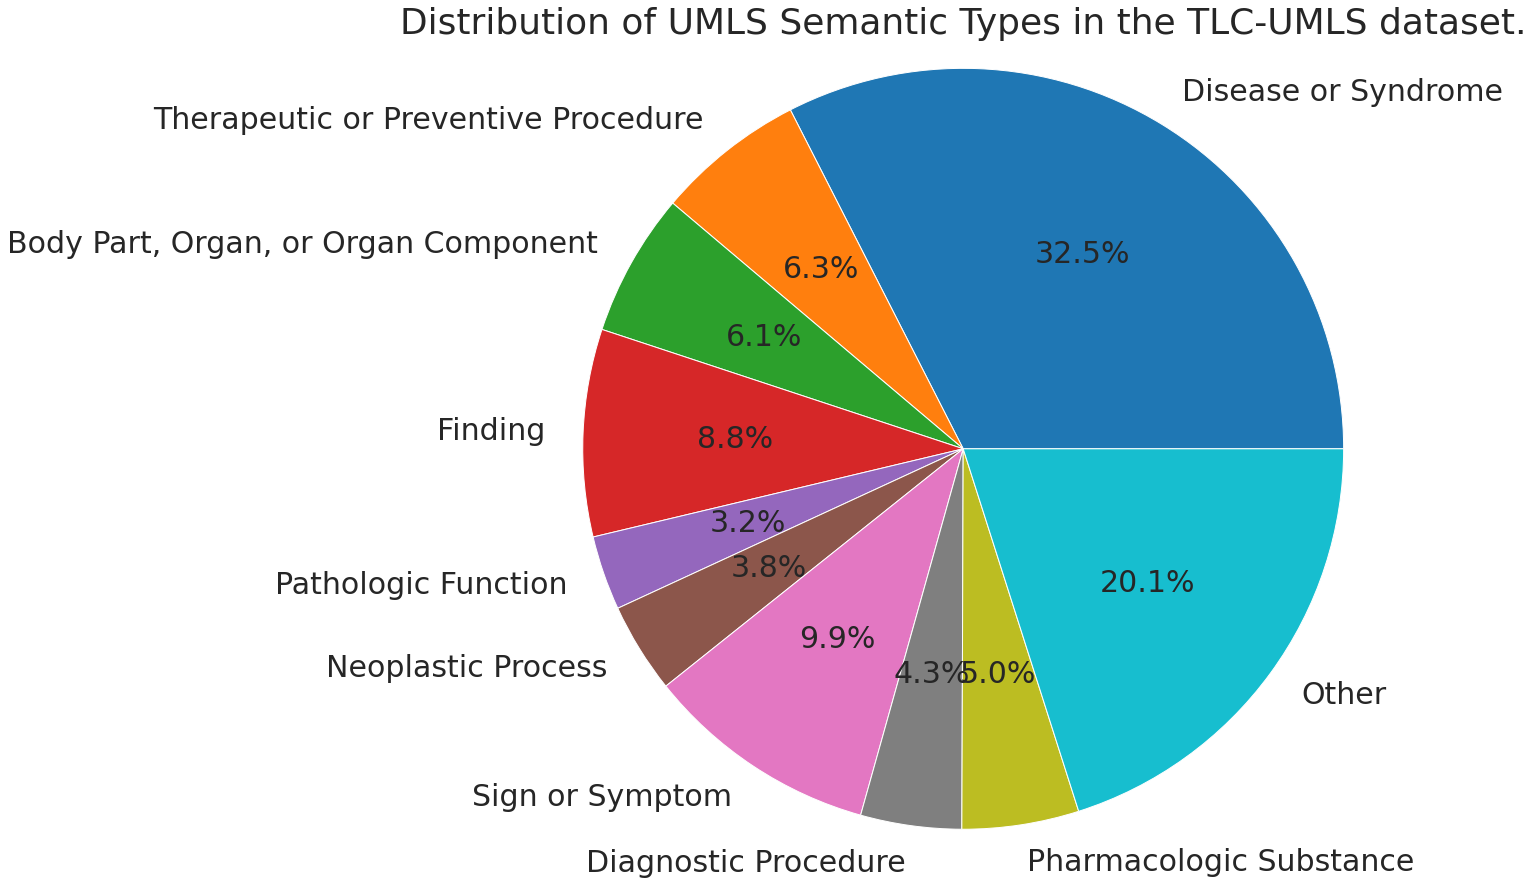

In [93]:
def create_pie_chart(data_dict, palette, minimum_count=10):
    """
    Create a pie chart from a dictionary. Keys with count less than 2 are grouped into 'Other' class.
    Args:
    data_dict: A dictionary where keys are names and values are counts.
    palette: A list of colors for the pie chart.
    """
    # Initialize a new dictionary for grouped data
    grouped_data_dict = {}

    # Initialize a counter for 'Other' class
    other_count = 0

    # Group keys with count less than 2 into 'Other' class
    for name, count in data_dict.items():
        if count < minimum_count:
            other_count += count
        else:
            grouped_data_dict[name] = count

    # Add 'Other' class to the dictionary
    grouped_data_dict['Other'] = other_count

    # Separate the names and their counts
    names, counts = zip(*grouped_data_dict.items())

    # Create a pie chart
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.pie(counts, labels=names, colors=palette, autopct='%1.1f%%')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title("Distribution of UMLS Semantic Types in the TLC-UMLS dataset.")

    plt.show()


# Define a list of hex string colors
hex_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2",
              "#7f7f7f", "#bcbd22", "#17becf"]

create_pie_chart(data_dict=type_name_counts, palette=hex_colors, minimum_count=10)

In [94]:
len(type_name_counts)

45

In [97]:
print(f"{most_common_cui_names=}\n")
print(f"{most_common_cuis=}\n")
print(f"{most_common_mentions=}\n")
print(f"{most_common_filtered_words=}\n")
print()
print("most common semantic types from UMLs in the TLC-UMLS", type_name_counts)
print()



most_common_cui_names=['Pyelonephritis', 'Ultrasonography', 'Diarrhea', 'Calculi', 'Pyocystis', 'Gastritis', 'Kidney Calculi', 'Endoscopy of stomach', 'colonoscopy', 'Nausea']

most_common_cuis=[('C0034186', 374), ('C0041618', 370), ('C0011991', 356), ('C0006736', 256), ('C0268838', 256), ('C0017152', 222), ('C0022650', 198), ('C0017195', 182), ('C0009378', 176), ('C0027497', 170)]

most_common_mentions=[('Ultraschall', 368), ('Nierenbeckenentzündung', 362), ('Stein', 356), ('Durchfall', 356), ('Blasenentzündung', 256), ('Gastritis', 222), ('Magenspiegelung', 182), ('Darmspiegelung', 176), ('Übelkeit', 170), ('Steine', 144)]

most_common_filtered_words=[('Thread', 2370), ('Text', 1868), ('Ich', 738), ('wurde', 511), ('schon', 475), ('Durchfall', 465), ('mal', 465), ('Ultraschall', 463), ('Stein', 448), ('Nierenbeckenentzündung', 416), ('Urin', 363), ('Hallo', 339), ('ja', 327), ('Blasenentzündung', 320), ('Gastritis', 319), ('mehr', 314), ('Schmerzen', 310), ('seit', 302), ('Übelkeit',

In [45]:
with open(TLCPaths.project_data_path / "cometa_cuis.json") as f:
    cometa_cuis = json.load(f)

In [49]:
semantic_types = get_semantic_types(cometa_cuis)
semantic_types = [t for l in semantic_types.values() for t in l]  # flattened values

type_counter = Counter(semantic_types)
type_name_counts = {get_type_name(t): count for t, count in type_counter.items()}



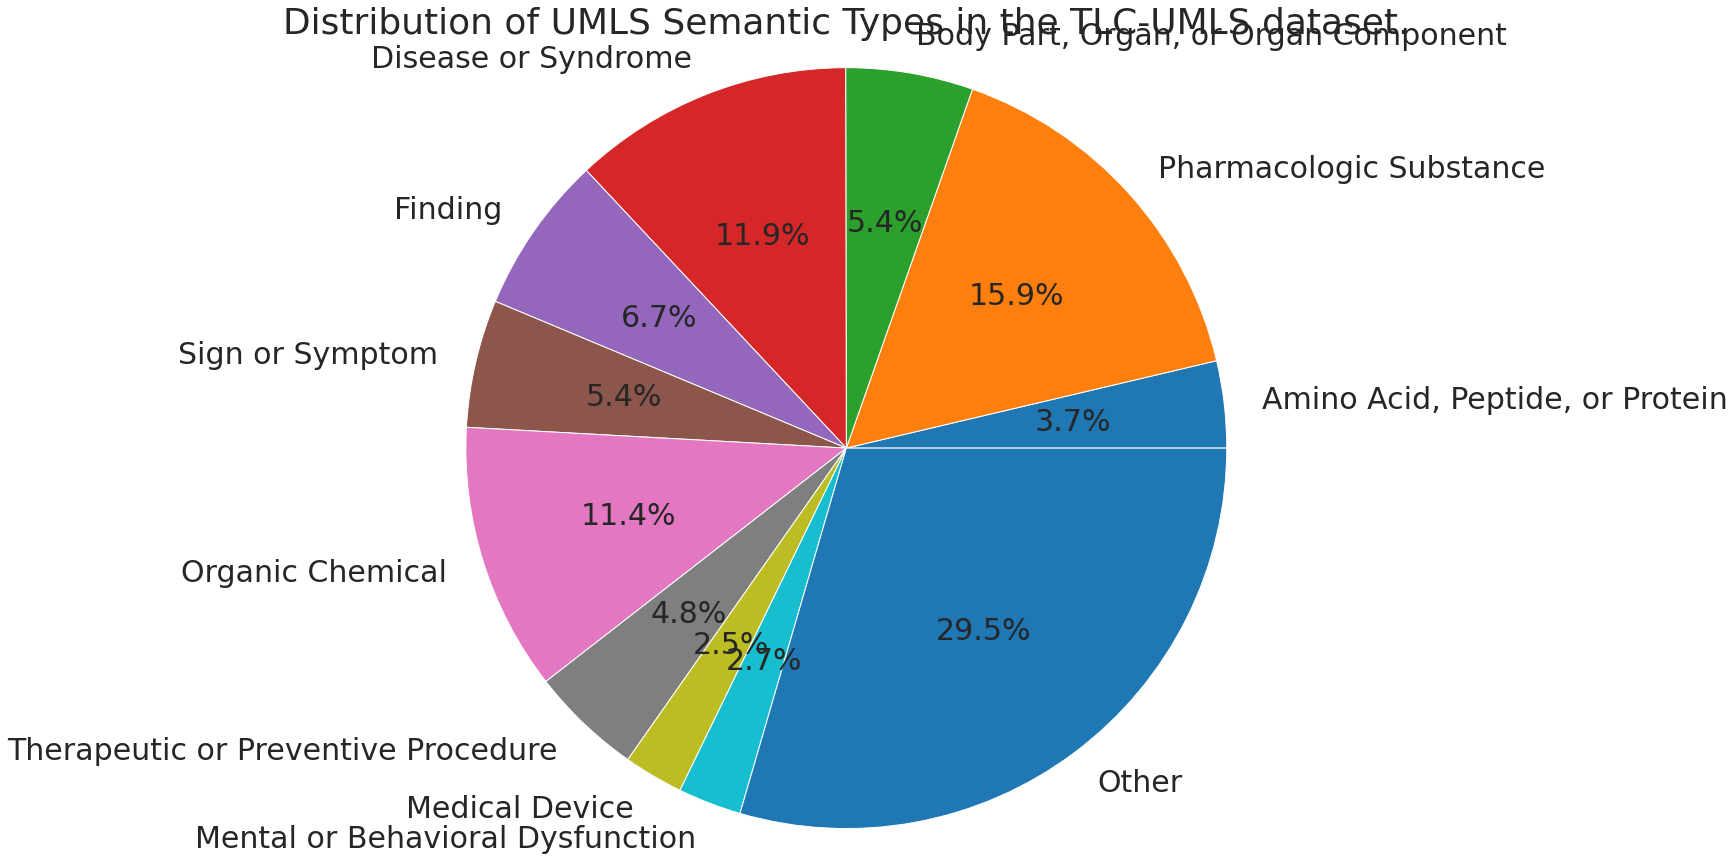

In [50]:
create_pie_chart(data_dict=type_name_counts, palette=hex_colors, minimum_count=100)
